In [40]:
"""
install ImageNet label and store into list
"""
import os
os.system("wget -O ImageNet_label https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt")

label = []
with open("ImageNet_label") as f:
    label = [i.split("'")[1] for i in f.readlines()]

# print(label)

--2021-08-18 11:18:34--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘ImageNet_label’

     0K .......... .......... .........                       100% 3.42M=0.009s

2021-08-18 11:18:34 (3.42 MB/s) - ‘ImageNet_label’ saved [30564/30564]



In [41]:
"""
class timer for recording exe time
"""
import time
class timer():
    def __init__(self):
        self.startTime=0
        self.endTime=0
        self.totaltime=0
    def start(self):
        self.startTime=time.time()
    def end(self):
        self.totaltime =time.time()-self.startTime

In [42]:
"""
img transform 
"""
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
		std=[0.229, 0.224, 0.225])
])

In [43]:
"""
save pytorch resnet model
"""
import torch
import torchvision

resnet50 = torchvision.models.resnet50(pretrained=True, progress=False).eval()
#print(resnet50)
torch.save(resnet50,"resnet.pt")

In [44]:
"""
load pytorch model
"""

load_torch_timer = timer()
load_torch_timer.start()
resnet_pytorch = torch.load("resnet.pt")
load_torch_timer.end()
print("load pytorch model: %f s" % (load_torch_timer.totaltime))

load pytorch model: 0.039026 s


In [45]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
img = Image.open('cat.png')
img = transform(img)
img = torch.unsqueeze(img, 0)
print(img.size())

torch.Size([1, 3, 224, 224])


In [46]:
""" 
pytorch inference 
"""

infer_torch_timer = timer()
infer_torch_timer.start()
output = resnet_pytorch(img)
infer_torch_timer.end()

print(output.size())
output = output.squeeze()
print(output.size())
print("pytorch time: %fs"%(infer_torch_timer.totaltime))

sum = 0
for i in output:
    sum += i
# print(output)

torch.Size([1, 1000])
torch.Size([1000])
pytorch time: 0.044211s


In [47]:
"""
pytorch result
"""

import torch.nn.functional as F
_, index = torch.sort(output, descending=True)
percentage = F.softmax(output)

result_torch = [(label[i],percentage[i].item()*100) for i in index[:5]]
for j in result_torch:
    print("%-25s | %08.5f"%(j[0],j[1])+"%")

tabby, tabby cat          | 43.14913%
tiger cat                 | 29.68253%
Egyptian cat              | 25.96065%
tiger, Panthera tigris    | 00.34236%
lynx, catamount           | 00.30307%


In [48]:
""" 
load Pytorch model to GPU
"""

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_pytorch_gpu = torch.load("resnet.pt")
resnet_pytorch_gpu.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
"""
Pytorch inference on GPU
"""

from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
img = Image.open('cat.png')
img = transform(img)
img = torch.unsqueeze(img, 0)
print(img.size())

infer_torch_gpu_timer = timer()
infer_torch_gpu_timer.start()
img.to(device)
output = resnet_pytorch(img)
infer_torch_gpu_timer.end()

output = output.squeeze()
print("pytorch time: %fs"%(infer_torch_gpu_timer.totaltime))

torch.Size([1, 3, 224, 224])
pytorch time: 0.035235s


In [50]:
"""
result of Pytorch on PGU
"""

_, index = torch.sort(output, descending=True)
percentage = F.softmax(output)

result_torch_gpu = [(label[i],percentage[i].item()*100) for i in index[:5]]
for j in result_torch_gpu:
    print("%-25s | %08.5f"%(j[0],j[1])+"%")

tabby, tabby cat          | 43.14913%
tiger cat                 | 29.68253%
Egyptian cat              | 25.96065%
tiger, Panthera tigris    | 00.34236%
lynx, catamount           | 00.30307%


In [51]:
"""
image process and transform
"""
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
img = Image.open('cat.png')
img = transform(img)
img = torch.unsqueeze(img, 0)
print(img.size())

torch.Size([1, 3, 224, 224])


In [52]:
""" 
pytorch to onnx and save as "resnet.onnx"
"""

import torch.onnx
BATCH_SIZE=1
dummy_input=torch.randn(BATCH_SIZE, 3, 224, 224)
torch.onnx.export(resnet50, dummy_input, "resnet.onnx", verbose=False,input_names = ['input'], output_names = ['output'])

In [53]:
"""
load onnx model
"""

import onnxruntime as rt

"""
Log severity level for a particular Run() invocation. 
0:Verbose, 
1:Info, 
2:Warning. 
3:Error, 
4:Fatal. 

Default is 2.
"""
rt.set_default_logger_severity(2)

print(rt.get_device())
load_onnx_timer = timer()
load_onnx_timer.start()
resnet_onnx = rt.InferenceSession("resnet.onnx")
load_onnx_timer.end()
print("load pytorch model: %f s" % (load_onnx_timer.totaltime))

GPU
load pytorch model: 0.061211 s


In [54]:
""" 
onnx inference 
"""

def to_np(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

infer_onnx_timer = timer()
ort_input = {resnet_onnx.get_inputs()[0].name:to_np(img)}
infer_onnx_timer.start()
output = resnet_onnx.run(None,ort_input)[0][0]
infer_onnx_timer.end()

output = torch.tensor(output)

In [55]:
_, index = torch.sort(output, descending=True)
percentage = F.softmax(output)

print(index[:5])
result_onnx = [(label[i],percentage[i].item()*100) for i in index[:5]]
for j in result_onnx:
    print("%-25s | %08.5f"%(j[0],j[1])+"%")

tensor([281, 282, 285, 292, 287])
tabby, tabby cat          | 43.14909%
tiger cat                 | 29.68262%
Egyptian cat              | 25.96060%
tiger, Panthera tigris    | 00.34236%
lynx, catamount           | 00.30307%


In [56]:
print("load time")
print("Pytorch : %fs" % (load_torch_timer.totaltime))
print("onnx    : %fs" % (load_onnx_timer.totaltime))

print("-"*50)
print("infer time")
print("Pytorch : %fs" % (infer_torch_timer.totaltime))
print("onnx    : %fs" % (infer_onnx_timer.totaltime))

load time
Pytorch : 0.039026s
onnx    : 0.061211s
--------------------------------------------------
infer time
Pytorch : 0.044211s
onnx    : 0.095819s


In [57]:
import tensorrt as trt

print(trt.__version__)

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

def build_engine(onnx_path, shape = [1,224,224,3]):

   """
   create the TensorRT engine
   Args:
      onnx_path : Path to onnx_file. 
      shape : Shape of the input of the ONNX file. 
  """
   with trt.Builder(TRT_LOGGER) as builder, builder.create_network(1) as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
       builder.max_workspace_size = (256 << 20)
       """256 MB"""
       with open(onnx_path, 'rb') as model:
           parser.parse(model.read())
       network.get_input(0).shape = shape
       engine = builder.build_cuda_engine(network)
       return engine

def save_engine(engine, file_name):
   buf = engine.serialize()
   with open(file_name, 'wb') as f:
       f.write(buf)

def load_engine(trt_runtime, plan_path):
   with open(plan_path, 'rb') as f:
       engine_data = f.read()
   engine = trt_runtime.deserialize_cuda_engine(engine_data)
   return engine

7.2.3.4


In [58]:
from onnx import ModelProto

BATCH_SIZE=1
dummy_input=torch.randn(BATCH_SIZE, 3, 224, 224)
resnet50 = torchvision.models.resnet50(pretrained=True, progress=False).eval()
torch.onnx.export(resnet50, dummy_input, "resnet.onnx", verbose=False,input_names = ['input'], output_names = ['output'])

onnx_path = "resnet.onnx"
trt_path  = "resnet.plan"

model = ModelProto()
with open(onnx_path, "rb") as f:
  model.ParseFromString(f.read())

batch_size = 1
d0 = model.graph.input[0].type.tensor_type.shape.dim[1].dim_value
d1 = model.graph.input[0].type.tensor_type.shape.dim[2].dim_value
d2 = model.graph.input[0].type.tensor_type.shape.dim[3].dim_value
shape = [batch_size , d0, d1 ,d2]

"""
build engine and start timer to get total build time
"""
build_trt_timer = timer()
build_trt_timer.start()
trt_engine = build_engine(onnx_path,shape)
build_trt_timer.end()


"""
save engine as trt_path
"""
save_engine(trt_engine,trt_path)

In [59]:
print("build a tensorRT engine: %f s" %(build_trt_timer.totaltime))

build a tensorRT engine: 8.927228 s


In [60]:
import pycuda.driver as cuda
import pycuda.autoinit 

def allocate_buffers(engine, batch_size, data_type):
   """
   This is the function to allocate buffers for input and output in the device
   args:
      engine      : The path to the TensorRT engine. 
      batch_size  : The batch size for execution time.
      data_type   : The type of the data for input and output, for example trt.float32. 
   
   return:
      h_input_1   : Input in the host.
      d_input_1   : Input in the device. 
      h_output_1  : Output in the host. 
      d_output_1  : Output in the device. 
      stream      : CUDA stream.
   """

   # Determine dimensions and create page-locked memory buffers (which won't be swapped to disk) to hold host inputs/outputs.
   h_input_1 = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(0)), dtype=trt.nptype(data_type))
   h_output = cuda.pagelocked_empty(batch_size * trt.volume(engine.get_binding_shape(1)), dtype=trt.nptype(data_type))
   # Allocate device memory for inputs and outputs.
   d_input_1 = cuda.mem_alloc(h_input_1.nbytes)

   d_output = cuda.mem_alloc(h_output.nbytes)
   # Create a stream in which to copy inputs/outputs and run inference.
   stream = cuda.Stream()
   return h_input_1, d_input_1, h_output, d_output, stream 

def load_images_to_buffer(pics, pagelocked_buffer):
   preprocessed = np.asarray(pics).ravel()
   np.copyto(pagelocked_buffer, preprocessed) 

def do_inference(engine, pics_1, h_input_1, d_input_1, h_output, d_output, stream, batch_size):
   """
   This is the function to run the inference
   Args:
      engine      : Path to the TensorRT engine 
      pics_1      : Input images to the model.  
      h_input_1   : Input in the host         
      d_input_1   : Input in the device 
      h_output_1  : Output in the host 
      d_output_1  : Output in the device 
      stream      : CUDA stream
      batch_size  : Batch size for execution time
   
   Output:
      The list of output images

   """

   load_images_to_buffer(pics_1, h_input_1)

   with engine.create_execution_context() as context:

      """ copy data from host to device """
      cuda.memcpy_htod_async(d_input_1, h_input_1, stream)

      # Run inference.
      context.profiler = trt.Profiler()
      context.execute(batch_size=1, bindings=[int(d_input_1), int(d_output)])

      # Transfer predictions back from the GPU.
      cuda.memcpy_dtoh_async(h_output, d_output, stream)

      # Synchronize the stream
      stream.synchronize()
      
      # Return the host output.
      
      return h_output

In [61]:
"""
load tensorRT engine
"""

load_trt_timer = timer()
load_trt_timer.start()
resnet_trt = load_engine(trt_runtime,trt_path)
load_trt_timer.end()

In [62]:
print("load a tensorRT engine: %f s" %(load_trt_timer.totaltime))

load a tensorRT engine: 0.507418 s


In [63]:
"""
inference step
   workflow:
      1. allocate buffer for input and output in GPU
      2. copy data from host to device
      3. run inference in GPU
      4. copy result from GPU to the host
      5. reshape (optional)
"""

""" allocate buffer """

host_input, device_input, host_output, device_output, stream = allocate_buffers(
    engine = resnet_trt,
    batch_size = 1,
    data_type = trt.float32)

In [64]:
img = Image.open('cat.png')
img = transform(img)
img = torch.unsqueeze(img, 0)
print(img.size())

torch.Size([1, 3, 224, 224])


In [65]:
""" inference """
infer_trt_timer = timer()
infer_trt_timer.start()
output = do_inference(
    engine    = resnet_trt,
    pics_1    = img,
    h_input_1 = host_input,
    d_input_1 = device_input,
    h_output  = host_output,
    d_output  = device_output,
    stream    = stream,
    batch_size= 1,
)
infer_trt_timer.end()

Conv_0 + Relu_1: 0.08096ms
MaxPool_2: 0.017728ms
Conv_3 + Relu_4: 0.019552ms
Conv_5 + Relu_6: 0.050528ms
Conv_7: 0.0408ms
Conv_8 + Add_9 + Relu_10: 0.046816ms
Conv_11 + Relu_12: 0.043648ms
Conv_13 + Relu_14: 0.049952ms
Conv_15 + Add_16 + Relu_17: 0.046208ms
Conv_18 + Relu_19: 0.043552ms
Conv_20 + Relu_21: 0.05072ms
Conv_22 + Add_23 + Relu_24: 0.046048ms
Conv_22 + Add_23 + Relu_24 output reformatter 0: 0.030784ms
Conv_25 + Relu_26: 0.063904ms
Conv_27 + Relu_28: 0.073728ms
Conv_29: 0.036672ms
Conv_30 + Add_31 + Relu_32: 0.069056ms
Conv_33 + Relu_34: 0.038528ms
Conv_35 + Relu_36: 0.0736ms
Conv_37 + Add_38 + Relu_39: 0.042816ms
Conv_40 + Relu_41: 0.038368ms
Conv_42 + Relu_43: 0.073536ms
Conv_44 + Add_45 + Relu_46: 0.04272ms
Conv_47 + Relu_48: 0.038208ms
Conv_49 + Relu_50: 0.074272ms
Conv_51 + Add_52 + Relu_53: 0.04304ms
Conv_54 + Relu_55: 0.061504ms
Conv_56 + Relu_57: 0.134048ms
Conv_58: 0.061344ms
Conv_59 + Add_60 + Relu_61: 0.108416ms
Conv_59 + Add_60 + Relu_61 output reformatter 0: 0.01

In [66]:
print(type(output))
""" transform ndarray to Tensor """
output = torch.tensor(output)
print(type(output))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>


In [67]:
_, index = torch.sort(output, descending=True)
percentage = F.softmax(output)

print(index[:5])
result_trt = [(label[i],percentage[i].item()*100) for i in index[:5]]
for j in result_trt:
    print("%-25s | %08.5f"%(j[0],j[1])+"%")

tensor([281, 282, 285, 292, 287])
tabby, tabby cat          | 43.14908%
tiger cat                 | 29.68258%
Egyptian cat              | 25.96064%
tiger, Panthera tigris    | 00.34236%
lynx, catamount           | 00.30307%


In [68]:
print("load time")
print("Pytorch      : %fs" % (load_torch_timer.totaltime))
print("onnx runtime : %fs" % (load_onnx_timer.totaltime))
print("tensorRT     : %fs" % (load_trt_timer.totaltime))

print("-"*50)
print("infer time")
print("Pytorch      : %fs" % (infer_torch_timer.totaltime))
print("Pytorch(GPU) : %fs" % (infer_torch_gpu_timer.totaltime))
print("onnx runtime : %fs" % (infer_onnx_timer.totaltime))
print("tensorRT     : %fs" % (infer_trt_timer.totaltime))

print("-"*50)
print("result")
print("  Pytorch:")
for j in result_torch:
    print("     %-25s | %08.5f"%(j[0],j[1])+"%")

print("  Pytorch(GPU):")
for j in result_torch_gpu:
    print("     %-25s | %08.5f"%(j[0],j[1])+"%")

print(" "*5+"-"*45)
print("  onnx:")
for j in result_onnx:
    print("     %-25s | %08.5f"%(j[0],j[1])+"%")

print(" "*5+"-"*45)
print("  tensorRT:")
for j in result_trt:
    print("     %-25s | %08.5f"%(j[0],j[1])+"%")

load time
Pytorch      : 0.039026s
onnx runtime : 0.061211s
tensorRT     : 0.507418s
--------------------------------------------------
infer time
Pytorch      : 0.044211s
Pytorch(GPU) : 0.035235s
onnx runtime : 0.095819s
tensorRT     : 0.009560s
--------------------------------------------------
result
  Pytorch:
     tabby, tabby cat          | 43.14913%
     tiger cat                 | 29.68253%
     Egyptian cat              | 25.96065%
     tiger, Panthera tigris    | 00.34236%
     lynx, catamount           | 00.30307%
  Pytorch(GPU):
     tabby, tabby cat          | 43.14913%
     tiger cat                 | 29.68253%
     Egyptian cat              | 25.96065%
     tiger, Panthera tigris    | 00.34236%
     lynx, catamount           | 00.30307%
     ---------------------------------------------
  onnx:
     tabby, tabby cat          | 43.14909%
     tiger cat                 | 29.68262%
     Egyptian cat              | 25.96060%
     tiger, Panthera tigris    | 00.34236%
     ly

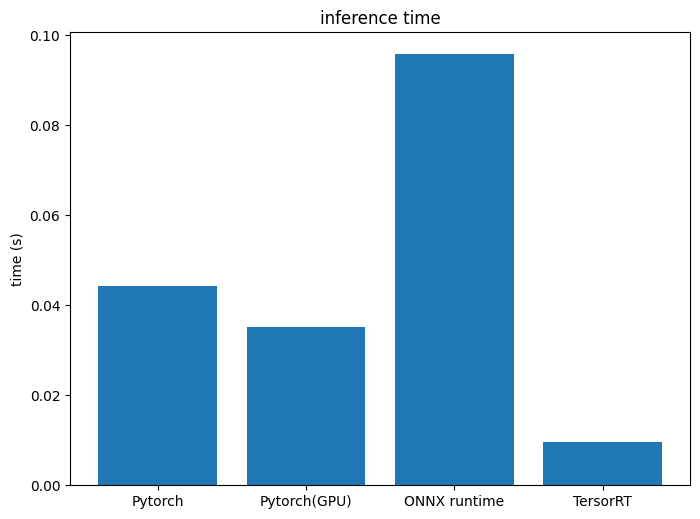

In [72]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8,6),dpi=100)

x_arr = [1,2,3,4]
x_name = ["Pytorch","Pytorch(GPU)","ONNX runtime","TersorRT"]
infer = [infer_torch_timer.totaltime,infer_torch_gpu_timer.totaltime,infer_onnx_timer.totaltime,infer_trt_timer.totaltime]
plt.bar(x_arr,infer)
plt.xticks(x_arr,x_name)
plt.title('inference time')
plt.ylabel('time (s)')
plt.show()

### TensorRT optimization

1. Layer & Tensor Fusion
    * 將 layer fusion 與移除沒用到的 layer
    * ![Imgur](https://i.imgur.com/MI07Wn0.png)
    * 如上圖中紅線匡選部份進行水平與垂直 fuse, 並且將 concat layer 給移除
2. Weight &Activation Precision Calibration
3. Kernel Auto-Tuning
4. Dynamic Tensor Memory
5. Multi-Stream Execution




### reference and issues:

* issue: **AttributeError: 'tensorrt.tensorrt.Builder' object has no attribute 'max_workspace_size'** 
    * error when nvidia-tensorrt is 8.x.x.x version
    * sol: remove nvidia-tensorrt 8.x.x.x and install 7.2.
    * ref: [(github issue link)](https://github.com/NVIDIA-AI-IOT/torch2trt/issues/557)
* issue: **AttributeError: module 'google.protobuf.descriptor' has no attribute '_internal_create_key**
    * error when ```protobuf``` version is  not equal to ```protoc```
        * show ```protobuf``` version: ```pip3 show protobuf```
        * show ```protoc``` version: ```protoc --version```
    * sol: 
        1. update protobuf version:  ```pip3 install --upgrade protobuf``` 
        2. install ```protoc``` if not exist:
            1. ```wget https://github.com/protocolbuffers/protobuf/releases/download/v3.17.3/protoc-3.17.3-linux-x86_64.zip```
            2. ```unzip protoc-3.17.3-linux-x86_64.zip```
            3. ```vim ~/.bashprofile``` and paste ```PATH=$PATH:/home/YOUR_HOST_NAME/bin```
            4. ```source ~/.bashprofile``` and ```echo $PATH``` to check whether ```/home/YOUR_HOST_NAME/bin``` exist or not.
    * ref: [stackoverflow linke](https://stackoverflow.com/questions/61922334/how-to-solve-attributeerror-module-google-protobuf-descriptor-has-no-attribu)
* issue: disable layer fusion 比對前後 perfermance?
    * 根據 [How to disable graph optimization(layer fusion)?](https://forums.developer.nvidia.com/t/how-to-disable-graph-optimization-layer-fusion/146343) 表示目前不提供, 但根據 [Disable layer fusion optimizations? ](https://github.com/NVIDIA/TensorRT/issues/252) 提到有方法可以間接達成(```network.mark_output(layer)```), 但會額外造成 [latency](https://github.com/NVIDIA/TensorRT/pull/495)
* [Imagenet label](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt)
* [NVIDIA onnx to tensorRT](https://developer.nvidia.com/blog/speeding-up-deep-learning-inference-using-tensorflow-onnx-and-tensorrt/)
    * [zh-cn (注意中文文檔中 ```save_engine``` 中的 code 有錯)](https://developer.nvidia.com/zh-cn/blog/speeding-up-deep-learning-inference-using-tensorflow-onnx-and-tensorrt/)
* [NVIDIA TensorRT Documentation](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#python_topics)
* [NVIDIA TensorRT Quick Start Guide](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html)
* [Jetson Nano 运用TensorRT加速引擎 上篇](https://www.rs-online.com/designspark/nvidia-cudagpujetson-nano-tensorrt-cn)
* [Jetson Nano 运用TensorRT加速引擎 下篇](https://www.rs-online.com/designspark/nvidia-cudagpujetson-nano-tensorrt-3-cn)
* [Pytorch EXPORTING A MODEL FROM PYTORCH TO ONNX AND RUNNING IT USING ONNX RUNTIME](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html)
* [ONNX runtime document](https://onnxruntime.ai/python/tutorial.html)
* [ONNX: Preventing Framework Lock in](https://towardsdatascience.com/onnx-preventing-framework-lock-in-9a798fb34c92)
* [TensorRT 实现深度网络模型推理加速](https://on-demand.gputechconf.com/gtc-cn/2018/pdf/CH8212.pdf)